# Problem Set - Gaussian Processes 

In [379]:
# The modules we will be using in this problem set
import util, test # These are local modules please feel free to read through them
from importlib import reload
reload(util)
reload(test)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

SyntaxError: invalid syntax (test.py, line 133)

## Gaussian Processes##

In this problem set, you will gain a deeper understanding of how Gaussian processes work by working on building a small library for Gaussian regression and classification. If you are having serious problems with this Pset please feel free to ask on Piazza or refer to [Gaussian Process: A Quick Introduction](A Quick Intro To Gaussian Processes.pdf).

### Problems
1. [Part 1 - Overview](#Part-1---Overview)
  1. [Problem 1 (10 pts)](#Problem-1---Making-a-Simple-Kernal-%2810-pts%29)
  2. [Problem 2 (5 pts)](#Problem-2---Making-a-Periodic-Kernal-%285-pts%29)
2. [Part 2 - Regression](#Part-2---Regression)
  1. [Problem 3 (5 pts)](#Problem-3---Getting-K-Matrix-%285-pts%29)
  2. [Problem 4 (20 pts)](#Problem-4---Regression-GP-%2820-pts%29)
  3. [Problem 5 (5 pts)](#Problem-5---Manual-Parameter-Tuning-%285-pts%29) 
  4. [Problem 6 (10 pts)](#Problem-6---Optimal-Parameters-%2810-pts%29)
3. [Part 3 - Classification](#Part-3---Classification)

# Part 1 - Overview

As covered in lecture, Gaussian Processes (GPs) allow us to infer entire functions from a set of observations without extensive initial parametrizing. The power of GPs lies in the covariance matrix, which specifies the pairwise covariance between all of the points in your dataset. Knowing how a point is affected by all other points in the data allows us to adjust our beliefs about the shape of the underlying function as well as the uncertainty around this function every time a new observation is made.
//The first step is to make the matrix where each entry specifies the similarity between 2 points.//

## Problem 1 - Making a Simple Kernel (10 pts)

In the following problem, you will be designing a kernel for a dataset where your belief at a certain point is most affected by its neighbors. This behavior occurs everywhere in nature: when throwing a ball in the air, your most recent location will tell you the most information about where the ball will be next. 

The kernel you will implement below is the one we have focused on in our lecture:


$$ k(x, x') = \overbrace{\sigma_{f}^{2}}^{\text{prior covariance}}\cdot\hspace{2em}\exp\bigg[{\frac{-(x-x')^{2}}{{2l^{2}}}}\bigg] + \overbrace{\sigma_{n}^{2}}^{\text{measurement noise}}\cdot\hspace{2em}\delta(x, x')\,$$ where $$\delta(x_{i}, x_{j})= \begin{cases} 1 & \text{if}\ x_{i}=x{j} \\0 & \text{otherwise} \end{cases}$$


You can see clearly that the maximum allowed covariance will be $ \sigma_{f}^{2} + \sigma_{n}^{2}$. If $x \approx x′$, then $k(x, x′)$ approaches this maximum, meaning $f(x)$ is nearly perfectly correlated with $f(x′)$. This is good: for our function to look smooth, neighbours must be alike.

Now if $x$ is very distant from $x′$, we have instead $k(x,x′) \approx 0$, i.e. the two points cannot ‘see’ each other. So, for example, during interpolation at new $x$ values, distant observations will have negligible effect. 

How much effect this separation has will depend on the length parameter, $l$. You will see the effect of changing $l$ later on in the assignment.

In the following cell, please implement the `kernel()` function as per the equation above.

In [369]:
def kernel(x0, x1, params, sigma_n):
    """
    Runs the exponential kernal function and returns output
    :param x0: numpy array with values of x
    :param x1: numpy array with values of x'
    :param params: [float simga_f, float l]
    :param sigma_n: float sigma_n
    :return: np.array(np.array) nested np.arrays where output[i,j] == k(x0[i],x1[j])
    """
    diff = np.subtract.outer(x0, x1) # USE THIS FOR CALCULATING (x-x') #+
    value = params[0]**2 * np.exp( -0.5 * (1.0/params[1]**2) * diff**2) #-
    value[np.where(diff == 0.0)] += sigma_n**2 #-
    return value #-

In [370]:
reload(test)
test.test_simple_kernel(kernel)

SyntaxError: invalid syntax (test.py, line 133)

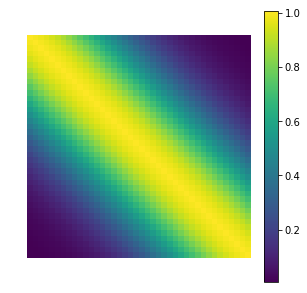

In [371]:
x = np.arange(-5, 5, 0.25)
sigma_n = 0.1
params = [1, 3]
K = kernel(x, x, params, sigma_n)
util.visiualize_kernel(K)

Here we can see the output of the kernel(x, x') where x = x' = [-5, -4.75, -4.5, ..., 4.5, 4.75, 5].
Along the diagonal you see that the kernel produces a higher value for when x and x' are near each other. Try changing the values of params. Notice how the band size changes. Think about the implications of these affects. This kernal attempts measure the similarity between any two points, this similarity measurement is very important in the Gaussian Process

## Problem 2 - Making a Periodic Kernel (5 pts)

In [372]:
def periodic_kernel(x0, x1, params, sigma_n):
    """
    Runs the Periodic kernal described above
    :param x0: numpy array with values of x
    :param x1: numpy array with values of x'
    :param params: [float simga_f1, float l, float simga_f1, float nu]
    :param sigma_n: float sigma_n
    :return: np.array(np.array) nested np.arrays where output[i,j] == k(x0[i] ,x1[j])
    """
    diff = np.subtract.outer(x0, x1) # USE THIS FOR CALCULATING (x-x') #+
    value = params[0]**2 * np.exp( -0.5 * (1.0/params[1]**2) * diff**2) #-
    value += params[2]**2 * np.exp(-2 * np.sin(params[3]*diff)**2) #-
    value[np.where(diff == 0.0)] += sigma_n**2 #-
    return value

In [373]:
test.test_periodic_kernel(periodic_kernel)

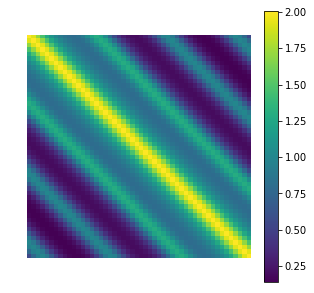

In [374]:
x = np.linspace(-5, 5, 50)
sigma_n = 0.1
params = [1, 2, 1, 1]
K = periodic_kernel(x, x, params, sigma_n)
util.visiualize_kernel(K)

Here we can see the output of the periodic_kernel(x, x') where x = x' = [-5, -4.75, -4.5, ..., 4.5, 4.75, 5].
Again notice the bands that formed along the diagonal; however, with the periodic function now notice that we have extra bands, these bands represent the periodic nature of the function. Try changing the values of params. Notice how the band size changes and the how tight the bands are change. Think about the implications of these affects.

# Part 2 - Regression

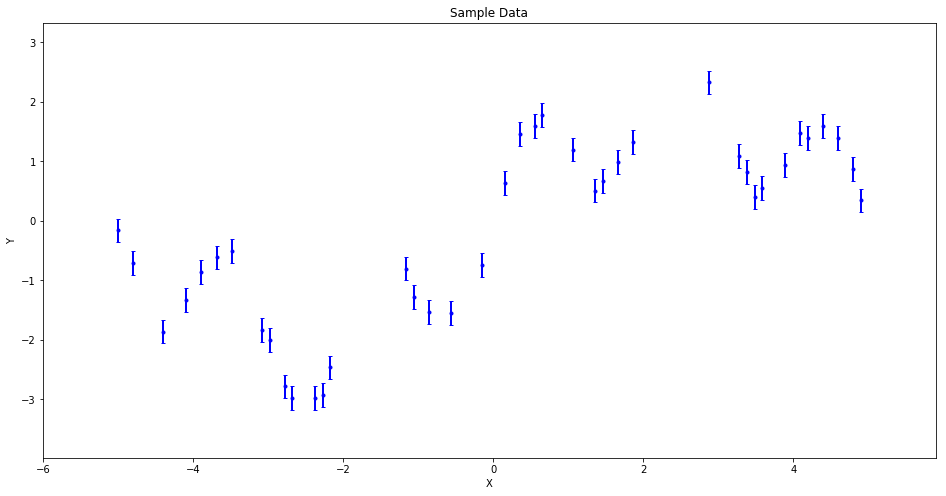

In [375]:
reload(util)
x, y = util.get_sample_data_1()
sigma_n = 0.1
util.scatter_raw_data(x, y, sigma_n)

## Problem 3 - Getting K Matrix (5 pts)

In [376]:
def get_Ks(x_new, x, kernel, theta):
    """
    Generates K, KS, and KSS by using the given kernel and theta
    :param x_new: numpy array of new data
    :param x: numpy array of data where we have sampled
    :param theta: list (params + [sigma_n]), this is a list that has the params (must be length
    of params which your kernel is expecting), but also has sigma_n in the last index.
    :return: np.array K, np.array KS, np.array KSS  all as described above.
    """
    K = kernel(x, x, theta[:-1], theta[-1]) # K #-
    KS = kernel(x_new, x, theta[:-1], theta[-1]) # K* #-
    KSS = kernel(x_new, x_new, theta[:-1], theta[-1]) # K** #-
    return K, KS, KSS #-

In [377]:
reload(test)
test.test_get_Ks(get_Ks, kernel)

SyntaxError: invalid syntax (test.py, line 133)

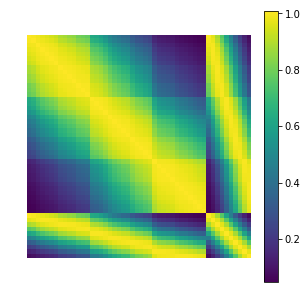

In [378]:
theta = [1, 4, sigma_n]
x_new = np.arange(-5,5)
K, KS, KSS = get_Ks(x_new, x, kernel, theta)
util.visiualize_Ks(K, KS, KSS)

Here you can see the joint Covariance Matrix this is $ \begin{bmatrix} K&K*^T\\ K*&K** \end{bmatrix} $. You should be able to see the the sharp cutoffs between the different sub-matricies. The values in K and K* are not as smooth as they were in the previous section because the samples in this section where not drawn uniformely; however, they were sorted by their x value so that we could see the bands. Here again you can play with the parameters of theta and see how the matrix changes. Notice the bands in K* these bands come from similarities bettween x_new values and the originally sampled xs.

## Problem 4 - Regression GP (20 pts)

In [335]:
def regression_GP(x_new, x, y, kernel, theta):
    """
    runs regression and returns y_new_bar and variance
    :param x_new: numpy array of new data
    :param x: numpy array of data where we have sampled
    :param y: numpy array of y values for data where we have sampled
    :param kernal:  the kernel function which we will be using
    :param theta: list (params + [sigma_n]), this is a list that has the params (must be length
    of params which your kernel is expecting), but also has sigma_n in the last index.
    :return: (np.array Y_new_bar, np.array var), the mean and variance (only diagonal of variance)
    of the gaussian that describes p(b|a)
    """
    K, KS, KSS = get_Ks(x_new, x, kernel, theta) # +

    y = np.matmul(np.matmul(KS, np.linalg.inv(K)),y) # -
    var = KSS - KS.dot(np.linalg.inv(K).dot(KS.T)) # -
    var = np.diagonal(var) # -
    return(y.squeeze(), var.squeeze()) # -

In [336]:
reload(test)
test.test_regression(regression_GP, kernel)

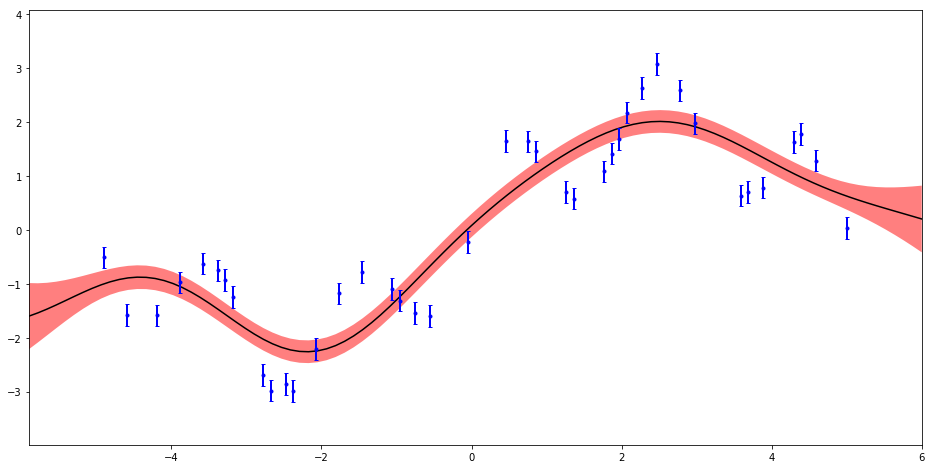

In [337]:
reload(util)
reload(test)
sigma_n = 0.1
theta = [1, 2, sigma_n]
util.solve_and_visualize(regression_GP, kernel, x, y, theta)

## Problem 5 - Manual Parameter Tuning (5 pts)

writing here 

Ask them what the happens as they change the values of theta above


What happens when you cange theta[0] (sigma_f)? 
What happens when you cange theta[1] (l)?
What happens when you cange sigma_n?

## Problem 6 - Optimal Parameters (10 pts)

Now we explore how to find the optimal parameters. You worked on tuning these parameters by hand in previous section. However, we can actually calculate the optimal parameters. The main idea is to maximize p($\theta$|data); however, we know that p($\theta$|data) $\propto$ p(data|$\theta$). We know that p(data|$\theta$) = p(y|x,$\theta$)  is the probability of sampling the data from a multivariate gausian with our covariance and $\mu$ = 0. So p(y|x, $\theta$)$=\frac{1}{(det(2\pi K))^{\frac{1}{2}}}e^{\frac{1}{2}y^TK^{-1}y}$. Our goal now is to maximize p(y|x, $\theta$). Since our current formula can be a bit computationally expensive, we can instead maximize log(p(y|x, $\theta$))$=-\frac{1}{2}y^TK^{-1}y - \frac{1}{2}det(K) - \frac{n}{2} log(2\pi)$. We can now use simple solve to find the optimal parameters of theta.

In [345]:
def regression_optimize_theta(x, y, sigma_n, kernel, params_0=[0.1, 0.1]):
    
    """
    Optimizes parameters for the data given by maximizing logp(data|parameters)
    :param x: numpy array of data where we have sampled
    :param y: numpy array of y values for data where we have sampled
    :sigma_n: float sigma_n
    :param kernal: the kernel function which we will be using
    :param params_0: list params_0 this is a list that has the initial params (must be length
    of params which your kernel is expecting) from this point the optimizer will run.
    :return: list (optimal_params + [sigma_n]), this is a list that has the optimal parameterss (must be length
    of params which your kernel is expecting), but also has sigma_n in the last index.
    """
    
    def log_pY(theta):
        """
        Calculates the - log(p(y|parameters))
        :param theta: list params this is a list that has the params (must be length
        of params which your kernel is expecting)
        :return: float - log(p(y|parameters)) (using negative because our optimizer is a minimizer)
        """
        K = kernel(x, x, theta, sigma_n) #+
        log_k = np.linalg.slogdet(K)[1] #+
        output = 0.5 * np.matmul(np.matmul(y.T, np.linalg.inv(K)),y) #-
        output += 0.5 * log_k #-
        return output #-

    res = minimize(log_pY, params_0, method='nelder-mead', options={'xtol': 1e-8, 'disp': False}) #+
    return list(res.x) + [sigma_n] # +

In [348]:
test.test_regression_ouptimize_theta(regression_optimize_theta, kernel)

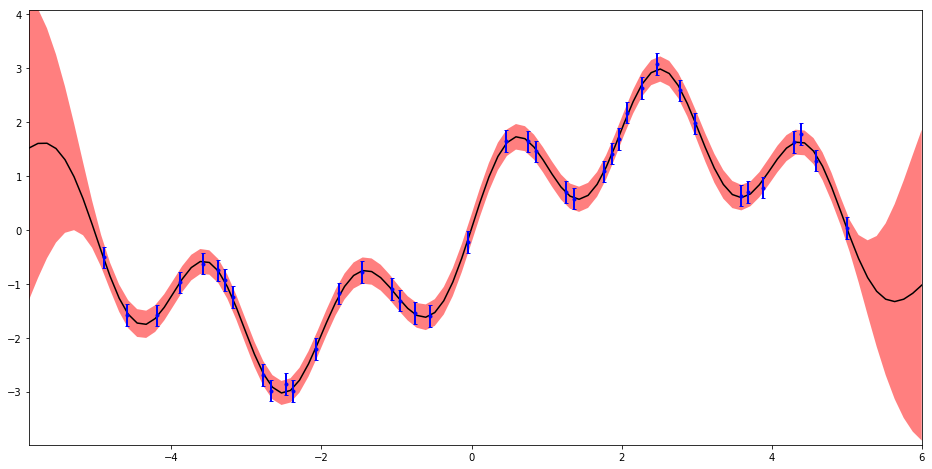

In [349]:
theta = regression_optimize_theta(x, y, sigma_n, kernel, [1, 0.1])
util.solve_and_visualize(regression_GP, kernel, x, y, theta)

## Smarter Covariance Matrix

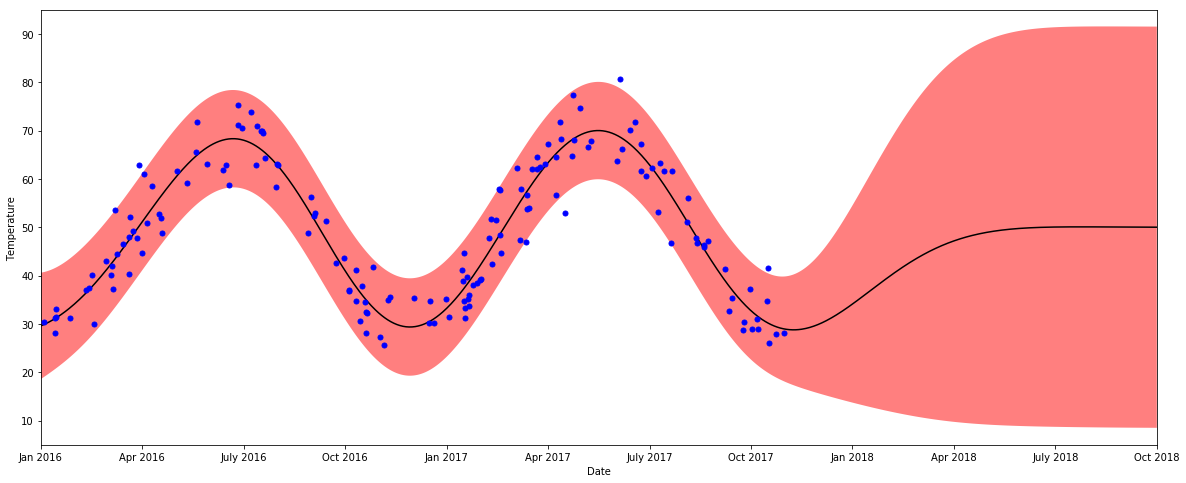

In [350]:
reload(util)
util.temperature_example(regression_GP, regression_optimize_theta, kernel, [1, 1])

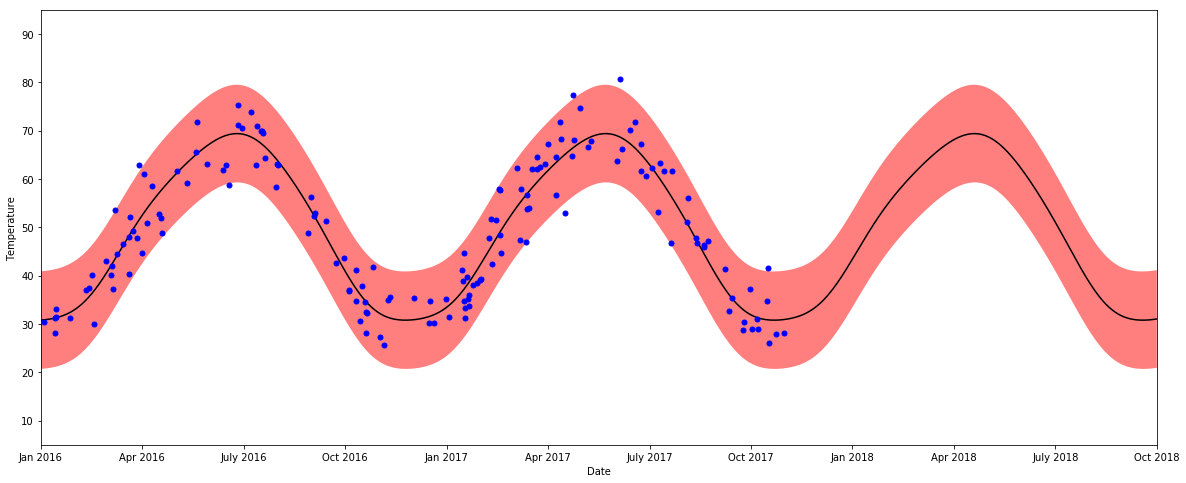

In [351]:
reload(util)
util.temperature_example(regression_GP, regression_optimize_theta, kernel, [1, 1])

When looking at different types of data, different covariance matricies can make a lot of sense. In the example above we can see Fake Temperature readings from random dates between jan 2016 - jan 2018. Using our simple exponential covariance function we fail capture the long term trends of the data set. However, by using a smarter choice of a kernel (the periodic kernel you wrote in Part 1) we can better model the dataset.

# Part 3 - Classification

## Problem 6

Description of a sigmoid function
<center>$S(x)$ = $\dfrac{1}{1+e^{-x}}$</center>
In this PSet use $S(x)$ as the sigmoid functiod in the implementation of the following problems

Implement $S(x)$.

In [352]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

In [353]:
test.test_sigmoid(sigmoid)

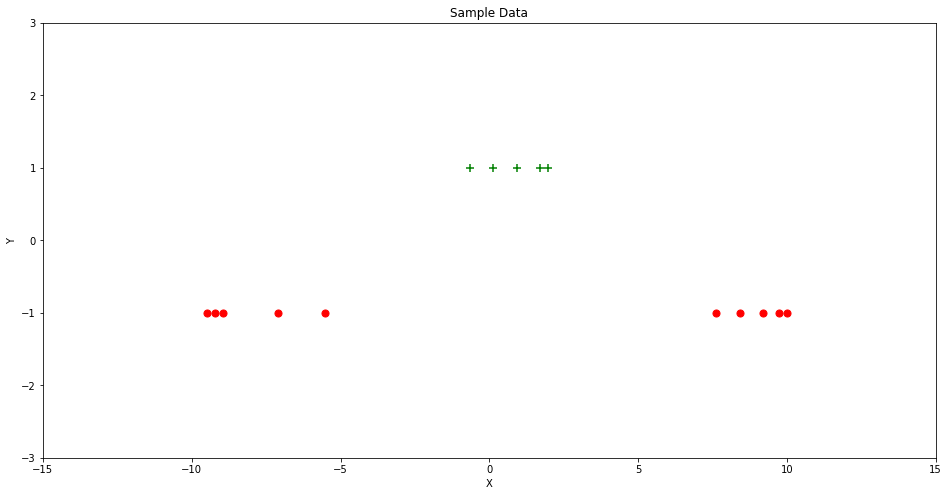

In [354]:
x, y = util.get_sample_classification_data()
util.scatter_raw_data_classification(x, y)

Solve for the covariance matrices K, K$*$, and K$**$ using the function you implemented above. Assume $\theta$ = [0.4, 5, 0]

In [355]:
theta = [.4, 5, 0]
K, KS, KSS = get_Ks(x, x, kernel, theta)

In [356]:
test.test_get_Ks(get_Ks, kernel)

Find f

In [357]:
def find_f(K, y):
    n = len(y) 
    f = np.zeros(n)  
    y_giv_f = np.zeros(n)
    grad = np.zeros(n)
    
    for i in range(0, 100):
        for j in range(n):
            y_giv_f[j] = sigmoid(f[j]*y[j])
            grad[j] = (1-y_giv_f[j])*y[j]
        f = np.array(np.matmul(K, grad)).flatten()
    for j in range(n):
        y_giv_f[j] = sigmoid(f[j]*y[j])
    return f, y_giv_f

In [358]:
test.test_find_f(find_f, get_Ks, kernel)

(array([-0.21328784, -0.2432166 , -0.22162858, -0.0952301 , -0.22880608,
         0.1138604 ,  0.07799312,  0.10705633,  0.10285364,  0.06440997,
        -0.21687374, -0.18320825, -0.25459694, -0.22592811, -0.19545694]),
 array([0.55312073, 0.56050618, 0.55518146, 0.52378955, 0.55695327,
        0.52843439, 0.5194884 , 0.52673855, 0.52569077, 0.51609693,
        0.55400692, 0.54567438, 0.56330764, 0.55624299, 0.54870926]))

Write a function that solves for W given f and y

In [359]:
def calc_W(f, y):
    n = len(y)
    W = np.zeros(n)
    for j in range(n):
        sigmoid_v = sigmoid(f[j]*y[j])
        W[j] = y[j]**2 * (1-sigmoid_v)*sigmoid_v
    return W

In [360]:
test.test_calc_W(calc_W, find_f, get_Ks, kernel)

array([0.24717819, 0.246339  , 0.24695501, 0.24943406, 0.24675633,
       0.24919149, 0.2496202 , 0.24928505, 0.24933998, 0.24974089,
       0.24708325, 0.24791385, 0.24599214, 0.24683673, 0.24762741])

Write a function that solves for $K'$

In [361]:
def calculate_KP(K, W):
    return K + (1.0/W)

In [327]:
test.test_calc_KP(calculate_KP, calc_W, find_f, get_Ks, kernel)

array([[4.19920802, 4.18677176, 4.16371002, 4.18150705, 4.20456848,
        4.05261461, 4.09009696, 4.03448455, 4.10167374, 4.08633255,
        4.06919959, 4.06482582, 4.0297888 , 4.07131903, 4.05071183],
       [4.19722594, 4.18875384, 4.17070176, 4.18479231, 4.19644143,
        4.06463598, 4.10534816, 4.04419421, 4.1167868 , 4.10146407,
        4.06988392, 4.06573411, 4.03257313, 4.07182836, 4.05225371],
       [4.18870958, 4.18524713, 4.17420846, 4.18303168, 4.18108334,
        4.08296397, 4.12532803, 4.05984553, 4.13529564, 4.12168358,
        4.07137583, 4.06767101, 4.03793698, 4.0729634 , 4.05539816],
       [4.19570132, 4.18853238, 4.17222638, 4.18501376, 4.19303396,
        4.06899534, 4.11044016, 4.04782416, 4.12165361, 4.10657052,
        4.07018506, 4.06612913, 4.03371989, 4.07205512, 4.05290849],
       [4.19376268, 4.17518144, 4.14527798, 4.1680339 , 4.21001382,
        4.03643156, 4.06624308, 4.02214522, 4.07653729, 4.06310608,
        4.06856643, 4.06396579, 4.02685502, 

Now we have all the necessary components. 

In [363]:
def GPC(x_new, x, y, kernel, theta):
    K = kernel(x, x, theta[:-1], theta[-1]) # K
    KS = kernel(x_new, x, theta[:-1], theta[-1]) # K*
    KSS = kernel(x_new, x_new, theta[:-1], theta[-1]) # K**
    
    f, y_giv_f = find_f(K, y)
    W = calc_W(f, y)
    
    KP = calculate_KP(K, W)

    f_bar = np.matmul(np.matmul(KS, np.linalg.inv(K)), f)    
    var = KSS - KS.dot(np.linalg.inv(KP).dot(KS.T))
    var = np.diagonal(var)
    return(f_bar.squeeze(), var.squeeze())


In [337]:
test.test_GPC(GPC, calculate_KP, calc_W, find_f, get_Ks, kernel)

(array([-0.12358141, -0.14374241, -0.16453429, -0.18526667, -0.20513215,
        -0.22320641, -0.23850061, -0.25003298, -0.25689161, -0.25822027,
        -0.25345174, -0.24217683, -0.22437528, -0.20032036, -0.17063489,
        -0.13634422, -0.09874625, -0.05931997, -0.0199786 ,  0.01773004,
         0.05167678,  0.08052257,  0.10262436,  0.11686701,  0.12255157,
         0.11943238,  0.10774679,  0.08808948,  0.06137639,  0.0290859 ,
        -0.00716741, -0.04561413, -0.0845241 , -0.12202557, -0.15666363,
        -0.18698549, -0.21194676, -0.23089067, -0.24347147, -0.24969576,
        -0.24981604, -0.24443344, -0.23429114, -0.22029877, -0.20339304,
        -0.18454416, -0.16465653, -0.14454104, -0.12489541, -0.10624699]),
 array([0.04560726, 0.04638068, 0.04697337, 0.04739024, 0.04767226,
        0.04785617, 0.04798349, 0.04806686, 0.0481184 , 0.04812877,
        0.04809796, 0.04804026, 0.04795314, 0.04784278, 0.04775372,
        0.04762002, 0.04753321, 0.04742531, 0.04741078, 0.047401

We provided you with $\theta$, now write a function that optimizes $\theta$ for you. Ouput of function is a list.

In [364]:
def optimize_theta(x, y, kernel, params_0=[0.1, 0.1], sigma_n=0.1):
    def log_pY(theta):
        K = np.matrix(kernel(x, x, theta, sigma_n))
        f, y_giv_f = find_f(K, y)
        W = calc_W(f, y)
        inv_k = np.linalg.inv(K)
        log_k = np.log(np.linalg.det(K) * np.linalg.det(inv_k+W))
        Y_giv_f = np.prod(y_giv_f)
        output = 0.5 * np.matmul(np.matmul(f.T, inv_k),f)
        output += 0.5 * log_k
        output -= np.log(Y_giv_f)
        return output

    res = minimize(log_pY, params_0, method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
    return list(res.x) + [sigma_n]

In [354]:
test.test_optimize_theta(optimize_theta, kernel)

[1.8165855832464077, 0.3220360502776173, 0.1]

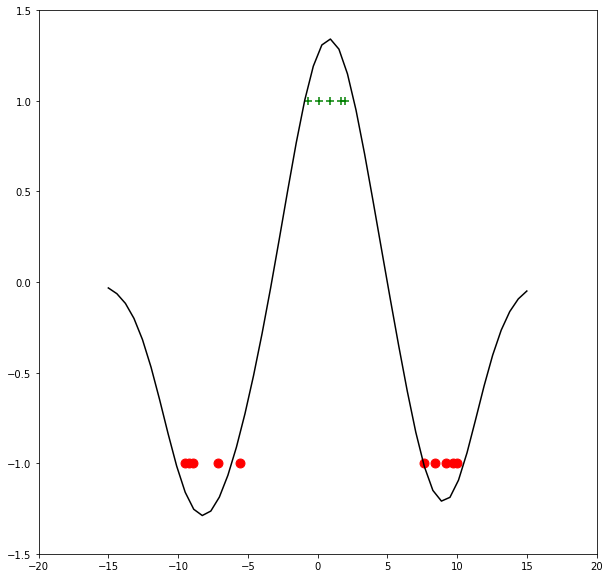

In [363]:
x_new = np.linspace(-15, 15, 50)
params_0 = [.4, 5]
sigma_n = 0.1
theta = optimize_theta(x, y, kernel, params_0=params_0, sigma_n=sigma_n)
y_bar, var = GPC(x_new, x, y, kernel, theta)

fig, axs = plt.subplots(1, 1)
for i in range(len(x)):
    if y[i] > 0:
        axs.scatter(x[i], y[i], 80, marker='+', color='g')
    else:
        axs.scatter(x[i], y[i], 80, marker='o', color='r')
axs.plot(x_new, y_bar,  color='k')
pretty_plot(fig, axs)